In [3]:
import os
import torch
import argparse
import numpy as np
import torch.utils.data

from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image

import torch.nn.functional as F

In [19]:
class AutoEncoder(nn.Module):
    def __init__(self, inp_size, hid_size):
        super(AutoEncoder, self).__init__()
#     def __init__(self, inp_size, hid_size, layers_number=1, dropout=None, activation=F.relu, lambda_=1):

        """
        Here you should define layers of your autoencoder
        Please note, if a layer has trainable parameters, it should be nn.Linear. 
        ## !! CONVOLUTIONAL LAYERS CAN NOT BE HERE !! ##
        However, you can use any noise inducing layers, e.g. Dropout.

        Your network must not have more than six layers with trainable parameters.
        :param inp_size: integer, dimension of the input object
        :param hid_size: integer, dimension of the hidden representation
        """
    
        self.activation = F.relu
        self.lambda_ = 1
        hidden_sizes = np.linspace(hid_size, inp_size, num=1 + 2).astype(int).tolist()
        self.encoder_layers = []
        self.decoder_layers = []
        
        for i in range(2):
#             if i == 1 and dropout:
#                 self.encoder_layers.append(nn.Dropout(dropout))

            self.encoder_layers.append(nn.Linear(hidden_sizes[-1 - i], hidden_sizes[-2 - i]))
            self.decoder_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            
        self.encoder_layers = nn.ModuleList(self.encoder_layers)
        self.decoder_layers = nn.ModuleList(self.decoder_layers)
    

    def encode(self, x):
        """
        Encodes objects to hidden representations (E: R^inp_size -> R^hid_size)

        :param x: inputs, Variable of shape (batch_size, inp_size)
        :return:  hidden represenation of the objects, Variable of shape (batch_size, hid_size)
        """
        
        for layer_index, encoder_layer in enumerate(self.encoder_layers):
            x = self.activation(encoder_layer(x))
#             if layer_index == 1 and self.dropout:
#                 x = encoder_layer(x)
#             else:
#                 x = self.activation(encoder_layer(x))
        
        return x

    def decode(self, h):
        """
        Decodes objects from hidden representations (D: R^hid_size -> R^inp_size)

        :param h: hidden represenatations, Variable of shape (batch_size, hid_size)
        :return:  reconstructed objects, Variable of shape (batch_size, inp_size)
        """
        
        for decoder_layer in self.decoder_layers:
            h = self.activation(decoder_layer(h))
        
        return h

    def forward(self, x):
        """
        Encodes inputs to hidden representations and decodes back.

        x: inputs, Variable of shape (batch_size, inp_size)
        return: reconstructed objects, Variable of shape (batch_size, inp_size)
        """

        return self.decode(self.encode(x))

    def loss_function(self, recon_x, x):
        """
        Calculates the loss function.

        :params recon_x: reconstructed object, Variable of shape (batch_size, inp_size)
        :params x: original object, Variable of shape (batch_size, inp_size)
        :return: loss
        """
        
        loss = torch.mean((x - recon_x) ** 2)
        for param in self.parameters():
            loss += self.lambda_ * (torch.sum(torch.abs(param)))
        return loss

In [21]:
def train(model, optimizer, train_loader, test_loader):
    for epoch in range(10):
        model.train()
        train_loss, test_loss = 0, 0
        for data, _ in train_loader:
            data = Variable(data).view(-1, 784)
            x_rec = model(data)
            loss = model.loss_function(x_rec, data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.data[0]
        print('=> Epoch: %s Average loss: %.3f' % (epoch, train_loss / len(train_loader.dataset)))

        model.eval()
        for data, _ in test_loader:
            data = Variable(data, volatile=True).view(-1, 784)
            x_rec = model(data)
            test_loss += model.loss_function(x_rec, data).data[0]

        test_loss /= len(test_loader.dataset)
        print('=> Test set loss: %.3f' % test_loss)

        n = min(data.size(0), 8)
        comparison = torch.cat([data.view(-1, 1, 28, 28)[:n], x_rec.view(-1, 1, 28, 28)[:n]])
        if not os.path.exists('./pics'): os.makedirs('./pics')
        save_image(comparison.data.cpu(), 'pics/reconstruction_' + str(epoch) + '.png', nrow=n)
    return model

In [22]:
def test_work():
    print('Start test')
    get_loader = lambda train: torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=train, download=True, transform=transforms.ToTensor()),
        batch_size=50, shuffle=True)
    train_loader, test_loader = get_loader(True), get_loader(False)
    
    try:
        model = AutoEncoder(inp_size=784, hid_size=20)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
    except Exception:
        assert False, 'Error during model creation'
        return

    try:
        model = train(model, optimizer, train_loader, test_loader)
    except Exception:
        assert False, 'Error during training'
        return

    test_x = Variable(torch.randn(1, 784))    
    rec_x, hid_x = model(test_x), model.encode(test_x)
    submodules = dict(model.named_children())
    layers_with_params = np.unique(['.'.join(n.split('.')[:-1]) for n, _ in model.named_parameters()])
    
    assert (hid_x.dim() == 2) and (hid_x.size(1) == 20),  'Hidden representation size must be equal to 20'
    assert (rec_x.dim() == 2) and (rec_x.size(1) == 784), 'Reconstruction size must be equal to 784'
    assert len(layers_with_params) <= 6, 'The model must have no more than 6 layers '
    assert np.all(np.concatenate([list(p.shape) for p in model.parameters()]) <= 800), 'All hidden sizes must be less than 800'
    print('Success!🎉')


In [23]:
test_work()

Start test
=> Epoch: 0 Average loss: 6.557
=> Test set loss: 1.603
=> Epoch: 1 Average loss: 1.614
=> Test set loss: 1.605
=> Epoch: 2 Average loss: 1.614
=> Test set loss: 1.617
=> Epoch: 3 Average loss: 1.614
=> Test set loss: 1.603
=> Epoch: 4 Average loss: 1.613
=> Test set loss: 1.623
=> Epoch: 5 Average loss: 1.613
=> Test set loss: 1.613
=> Epoch: 6 Average loss: 1.613
=> Test set loss: 1.622
=> Epoch: 7 Average loss: 1.613
=> Test set loss: 1.608
=> Epoch: 8 Average loss: 1.613
=> Test set loss: 1.603
=> Epoch: 9 Average loss: 1.613
=> Test set loss: 1.605
Success!🎉


In [5]:
def train(model, optimizer, train_loader, test_loader):
    train_losses = []
    test_losses = []
    for epoch in range(10):
        model.train()
        train_loss, test_loss = 0, 0
        for data, _ in train_loader:
            data = Variable(data).view(-1, 784)
            x_rec = model(data)
            loss = model.loss_function(x_rec, data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.data[0]
        if epoch == 0 or epoch == 10:
            print('=> Epoch: %s Average loss: %.3f' % (epoch, train_loss / len(train_loader.dataset)))
        train_losses.append(train_loss / len(train_loader.dataset))
        model.eval()
        for data, _ in test_loader:
            data = Variable(data, volatile=True).view(-1, 784)
            x_rec = model(data)
            test_loss += model.loss_function(x_rec, data).data[0]

        test_loss /= len(test_loader.dataset)
        if epoch == 0 or epoch == 10:
            print('=> Test set loss: %.3f' % test_loss)
        test_losses.append(test_loss)
        
        n = min(data.size(0), 8)
        comparison = torch.cat([data.view(-1, 1, 28, 28)[:n], x_rec.view(-1, 1, 28, 28)[:n]])
        if not os.path.exists('./pics'): os.makedirs('./pics')
        save_image(comparison.data.cpu(), 'pics/reconstruction_' + str(epoch) + '.png', nrow=n)
    return model, train_losses, test_losses

In [6]:
def test_work(layers_number=1, dropout=None, activation=F.relu, lambda_=1):
    print('Start test')
    get_loader = lambda train: torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=train, download=True, transform=transforms.ToTensor()),
        batch_size=50, shuffle=True)
    train_loader, test_loader = get_loader(True), get_loader(False)
    
    try:
        model = AutoEncoder(inp_size=784, hid_size=20)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
    except Exception:
        assert False, 'Error during model creation'
        return

    try:
        model, train_loss, test_loss = train(model, optimizer, train_loader, test_loader)
    except Exception:
        assert False, 'Error during training'
        return

    test_x = Variable(torch.randn(1, 784))    
    rec_x, hid_x = model(test_x), model.encode(test_x)
    submodules = dict(model.named_children())
    layers_with_params = np.unique(['.'.join(n.split('.')[:-1]) for n, _ in model.named_parameters()])
    
    assert (hid_x.dim() == 2) and (hid_x.size(1) == 20),  'Hidden representation size must be equal to 20'
    assert (rec_x.dim() == 2) and (rec_x.size(1) == 784), 'Reconstruction size must be equal to 784'
    assert len(layers_with_params) <= 6, 'The model must have no more than 6 layers '
    assert np.all(np.concatenate([list(p.shape) for p in model.parameters()]) <= 800), 'All hidden sizes must be less than 800'
    print('Success!🎉')
    return train_loss, test_loss

In [ ]:
layers_number = [1, 2, 3]
dropouts = [None, 0.3]

data = []

for layers_num in layers_number:
    for dropout in dropouts:
        data.append(test_work(layers_number=layers_num, dropout=dropout))

Start test
=> Epoch: 0 Average loss: 2.448
=> Test set loss: 0.083
Success!🎉
Start test
=> Epoch: 0 Average loss: 2.467
=> Test set loss: 0.083
Success!🎉
Start test
=> Epoch: 0 Average loss: 2.442
=> Test set loss: 0.083
Success!🎉
Start test
=> Epoch: 0 Average loss: 2.481
=> Test set loss: 0.082
Success!🎉
Start test
=> Epoch: 0 Average loss: 2.473
=> Test set loss: 0.083
Success!🎉
Start test
=> Epoch: 0 Average loss: 2.442
=> Test set loss: 0.083
Success!🎉


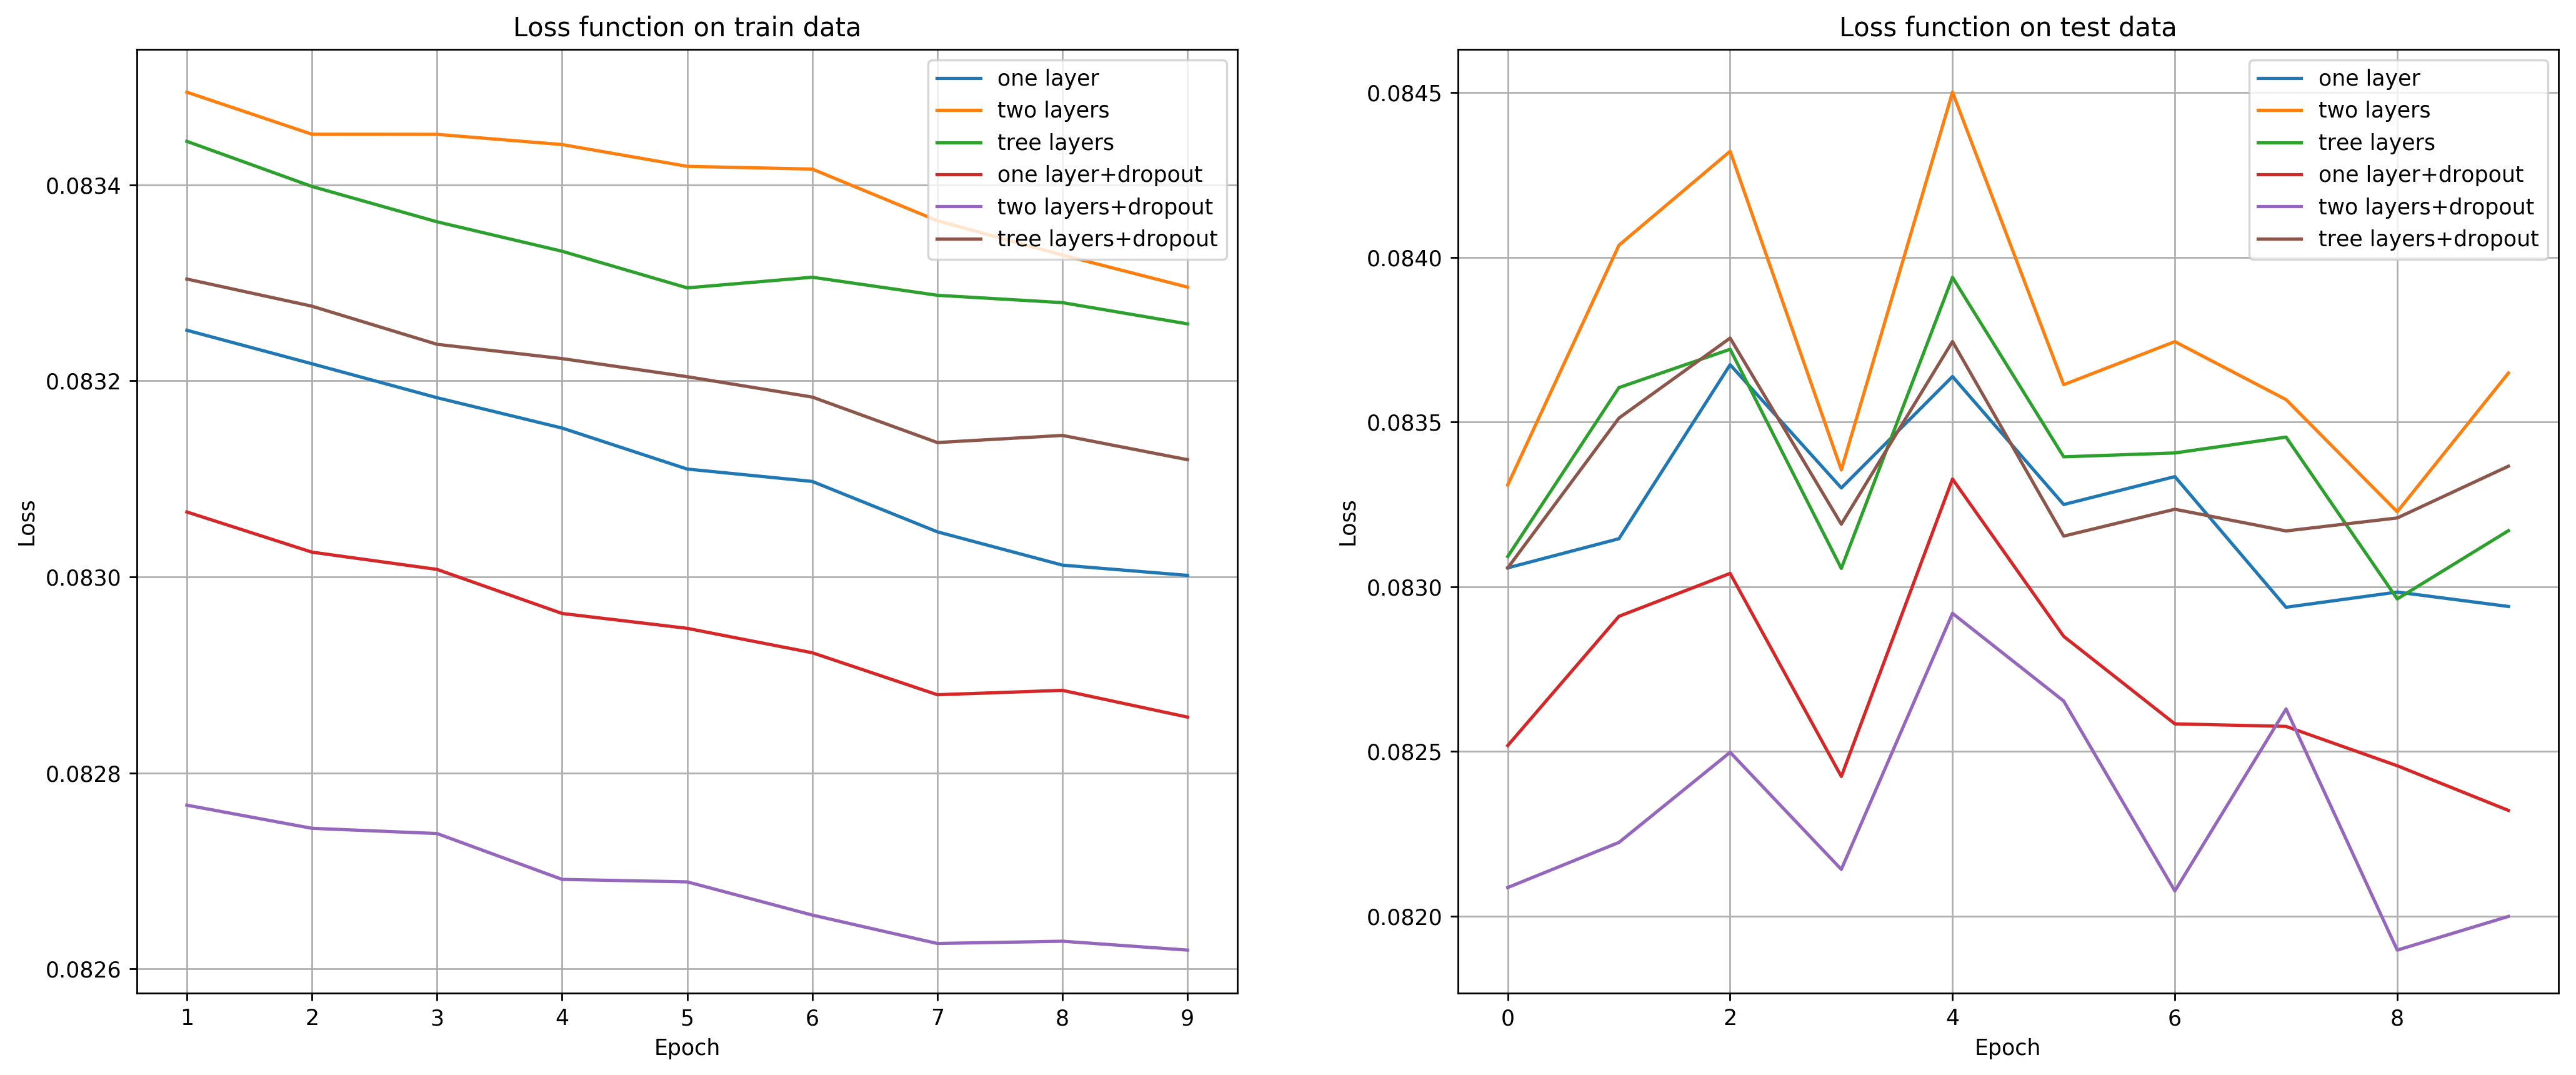

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8), dpi=250)
plt.subplot(1,2,1)
plt.plot(np.arange(1, 10), data[0][0][1:], label='one layer')
plt.plot(np.arange(1, 10), data[2][0][1:], label='two layers')
plt.plot(np.arange(1, 10), data[4][0][1:], label='tree layers')
plt.plot(np.arange(1, 10), data[1][0][1:], label='one layer+dropout')
plt.plot(np.arange(1, 10), data[3][0][1:], label='two layers+dropout')
plt.plot(np.arange(1, 10), data[5][0][1:], label='tree layers+dropout')
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss function on train data")

plt.subplot(1,2,2)
plt.plot(np.arange(0, 10), data[0][1], label='one layer')
plt.plot(np.arange(0, 10), data[2][1], label='two layers')
plt.plot(np.arange(0, 10), data[4][1], label='tree layers')
plt.plot(np.arange(0, 10), data[1][1], label='one layer+dropout')
plt.plot(np.arange(0, 10), data[3][1], label='two layers+dropout')
plt.plot(np.arange(0, 10), data[5][1], label='tree layers+dropout')
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss function on test data")

plt.savefig("res.jpg")
plt.show()